Лабораторная работа 5

Тема: Классификация с помощью нейронных сетей

Вариант 6 (датасет flight_delays)

Построить двухслойную нейронную сеть для классификации на два класса. Разбивку на классы сделать  по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать  разбиение на 2 кластера в задании 2 или 3. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из 3. (Вариант архитектуры сети - оба слоя полносвязных, первый слой с функцией активации Релу, а второй слой софтмакс или сигмоидная функция активации. Качество можно отслеживать с помощью точности, эпох должно быть не меньше 10; по поводу использования библиотек: предпочтительно написать не используя специальных библиотек для разработки нейронных сетей; если использовать всё-таки библиотеки, то лучше использовать тензорфло и керас в колабе; другие варианты - например, пайторч, тоже допустимы, но тогда обязательно оформление отчета).


Подключим необходимые библиотеки

In [47]:
#Подключаем библиотеки
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

Подготовим данные, нормализуем их и категории преобразуем в число

In [48]:
df = pd.read_csv('flight_delays.csv', sep=',')
cats = ["Month","DayofMonth","DayOfWeek", "UniqueCarrier","Origin","Dest","dep_delayed_15min"]

train = df[::2].copy()
check = df[1::2].copy()

for cat in cats:
  train[f'{cat}_cat'] = pd.factorize(train[cat], sort=True)[0]
  check[f'{cat}_cat'] = pd.factorize(check[cat], sort=True)[0]

# Выбираем категориальные и числовые данные
numer = train[["DepTime","Distance"]]
cater = train[[f"{cat}_cat" for cat in cats]]
numer_check = check[["DepTime","Distance"]]
cater_check = check[[f"{cat}_cat" for cat in cats]]

# Подготавливаем числовые данные
numer = pd.DataFrame(StandardScaler().fit_transform(numer))
numer.columns = ["DepTime_Scaled", "Distance_Scaled"]
numer_check = pd.DataFrame(StandardScaler().fit_transform(numer_check))
numer_check.columns = ["DepTime_Scaled", "Distance_Scaled"]

# Сливаем подготовленные данные в новый датасет
Df = pd.concat([numer, cater], axis=1, join='inner')
Df_check = pd.concat([numer_check, cater_check], axis=1, join='inner')

Получим t-SNE преобразование

In [49]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(Df_check)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Подготовим, скомпилируем и обучим модель

In [50]:
# Подготовить модель
model = keras.Sequential([
  keras.layers.Dense(len(Df.columns) - 1, activation=tf.nn.relu),
  keras.layers.Dense(2, activation=tf.nn.softmax)
])

# Скомпилировать модель
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Обучить модель
model.fit(Df.drop("dep_delayed_15min_cat", axis=1), Df["dep_delayed_15min_cat"], epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6854 - loss: 1.9113
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7835 - loss: 0.5751
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8069 - loss: 0.5212
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8058 - loss: 0.5148
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8071 - loss: 0.5097
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8069 - loss: 0.5081
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8056 - loss: 0.5108
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8053 - loss: 0.5084
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8039 - loss: 0.5119
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8057 - loss: 0.5054


Попытаемся получить точность на основе проверочной последовательности объектов

In [51]:
# Оценка на проверочной выборке
test_loss, test_acc = model.evaluate(Df_check.drop("dep_delayed_15min_cat", axis=1),
                                      Df_check["dep_delayed_15min_cat"])
print('Test accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8124 - loss: 0.5346
Test accuracy: 0.8081600069999695


Получаем предсказания

In [52]:
predictions = model.predict(np.array([row.drop("dep_delayed_15min_cat").values for index, row in Df_check.iterrows()]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Визуализировать данные

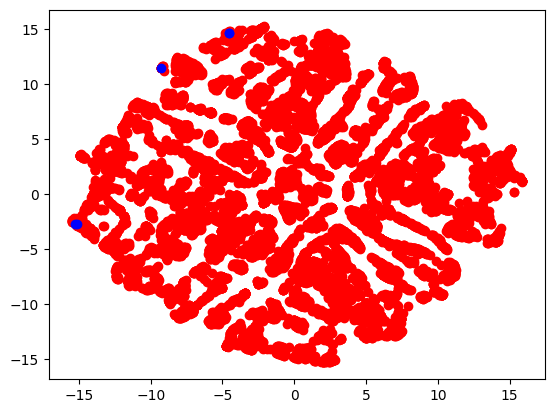

In [62]:
predictions_frame = pd.DataFrame(predictions, columns=["pred_1", "pred_2"])
tsne_frame = pd.DataFrame(tsne_results, columns=["tsne_x", "tsne_y"])
Df_check_appended = pd.concat([Df_check, predictions_frame, tsne_frame], axis=1, join='inner')
Df_check_a = Df_check_appended[Df_check_appended["pred_1"] >= 0.5]
Df_check_b = Df_check_appended[Df_check_appended["pred_1"] < 0.5]
plt.scatter(
      x = Df_check_a["tsne_x"],
      y = Df_check_a["tsne_y"],
      c = "red",
  )
plt.scatter(
      x = Df_check_b["tsne_x"],
      y = Df_check_b["tsne_y"],
      c = "blue",
  )
plt.show()

Вывод: как и в прошлых работах, несмотря на неплохие показатели точности, полученная нейронная сеть довольно плохо предсказывает, будет ли задержан полёт. Так из набора в 25000 объектов было выделено всего 4 объекта другого класса. Можно утверждать, что невозможно сделать вывод о том, будет ли задержан полёт, по указанным свойствам. Необходимо расширить датасет, например было бы неплохо добавить в него погодные условия, возможно они будут иметь большее значение при задержках в полёте.